In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import sys
from skimage.filters import threshold_otsu
from skimage.morphology import disk
from skimage.morphology import dilation
from PIL import Image
import pytesseract
import os

In [60]:

class resturant_menu_expert:
    
    def __init__(self ,path ,max_distance):
        orig_img = self.get_roi(path)

        img = orig_img.copy()
        img1 = self.invert(img)
        img2 = self.get_otsu(img1)

        img3 = self.disk_dilate(img2 ,5)
        final_angle = self.fast_featureless_rotation(img3)

        img4 = self.rotate_image(img2,final_angle)

        img5 = self.line_dilate(img4) 

        segs = self.dish_name_segmentation(img5 ,img4)
        text = self.ocr(segs)

        db = self.get_database()

        dish_names = self.OCR_Correction(text ,db , max_distance)

        output = self.get_finla_output(orig_img , dish_names ,final_angle)
        
        plt.figure(figsize=(15,15))
        plt.imshow(output)
        

    def get_roi(self ,img_path):
        img_raw = cv2.imread(img_path)
        roi = cv2.selectROI(img_raw)
        roi_cropped = img_raw[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        img = cv2.cvtColor(roi_cropped, cv2.COLOR_RGB2GRAY)
        return img

    def get_otsu(sefl ,img):
        otsu = threshold_otsu(img)
        binary = img > otsu

        res = np.zeros(binary.shape)

        for i in range(binary.shape[0]):
            for j in range(binary.shape[1]):
                if binary[i][j] == False:
                    res[i][j] = 0
                else:
                    res[i][j] = 255

        return res.astype(np.uint8)

    def invert(self ,img):
        return 255-img

    def disk_dilate(self ,img ,redius):
        selem = disk(redius)
        dilated = dilation(img, selem)
        return dilated

    def plot_gray(self ,img):
        plt.figure(figsize=(15,15))
        plt.imshow(img ,cmap='gray')

    def plot_rgb(self ,img):
        plt.figure(figsize=(15,15))
        plt.imshow(img)

    def get_bounding_boxes(self ,num_labels ,labels_im):
        componants = []

        for label in range(1,num_labels):
            comp = labels_im.copy()

            for i in range(labels_im.shape[0]):
                for j in range(labels_im.shape[1]):

                    if comp[i][j] == label:
                        comp[i][j] = 255
                    else:
                        comp[i][j] = 0

            comp = np.stack((comp,)*3, axis=-1)

            active_px = np.argwhere(comp!=0)
            active_px = active_px[:,[1,0]]

            x,y,w,h = cv2.boundingRect(active_px)
            componants.append( (label,w,h ,x,y))

        return componants

    def rotate_image(self ,mat, angle):
        height, width = mat.shape[:2]
        image_center = (width / 2, height / 2)

        rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1)

        radians = math.radians(angle)
        sin = math.sin(radians)
        cos = math.cos(radians)
        bound_w = int((height * abs(sin)) + (width * abs(cos)))
        bound_h = int((height * abs(cos)) + (width * abs(sin)))

        rotation_mat[0, 2] += ((bound_w / 2) - image_center[0])
        rotation_mat[1, 2] += ((bound_h / 2) - image_center[1])

        rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
        return rotated_mat

    def find_final_rotation(self ,img ,coarse_angle):
        aspect_ratios = []
        theta = []

        for angle in range(coarse_angle-10,coarse_angle+10):

            theta.append(angle)

            image_center = tuple(np.array(img.shape[1::-1]) / 2)
            rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
            res = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)

            num_labels, labels_im = cv2.connectedComponents(res)

            boxes = self.get_bounding_boxes(num_labels ,labels_im)

            aspect = 0
            for i in boxes:
                label = i[0]
                width = i[1]
                height = i[2]

                aspect += (height/width)

            aspect_ratios.append( aspect/len(boxes) )

        idx = aspect_ratios.index(min(aspect_ratios))
        return theta[idx]


    def fast_featureless_rotation(self ,img):

        aspect_ratios = []
        theta = []
        for angle in range(-90,90 ,10):

            theta.append(angle)
            
            image_center = tuple(np.array(img.shape[1::-1]) / 2)
            rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
            res = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)

            num_labels, labels_im = cv2.connectedComponents(res)

            boxes = self.get_bounding_boxes(num_labels ,labels_im)

            aspect = 0
            for i in boxes:
                label = i[0]
                width = i[1]
                height = i[2]

                aspect += (height/width)

            aspect_ratios.append( aspect/len(boxes) )

        idx = aspect_ratios.index(min(aspect_ratios))
        coarse_angle = theta[idx]

        final_angle =  self.find_final_rotation(img ,coarse_angle)

        return final_angle

    def line_dilate(self ,img):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10,2))
        dilate = cv2.dilate(img, kernel, iterations=2)

        return dilate

    def dish_name_segmentation(self ,dilated_img ,img):

        num_labels, labels_im = cv2.connectedComponents(dilated_img)
        boxes = self.get_bounding_boxes(num_labels ,labels_im)

        segments = []

        for box in boxes:
            label = box[0]
            w = box[1]
            h = box[2]
            x = box[3]
            y = box[4]
            
            cropped = img[y:y+h ,x:x+w]

            segments.append( [ 255-cropped , x,y,w,h ] )

        return segments 

    def ocr(self ,segs):
        final_text = []

        for i in segs:
            PIL_image = Image.fromarray(i[0])
            text = pytesseract.image_to_string(PIL_image)

            temp = text.split('\x0c')[0]
            line = temp.split('\n')[0]

            for j in [line]:
                final_text.append([j ,i[1] ,i[2] ,i[3] ,i[4] ])

        return final_text

    def get_database(self ):
        rootdir = '../img/menu_items'

        db = []
        for subdir, dirs, files in os.walk(rootdir):
            for file in files:
                temp = file.split('.')[0]
                db.append(temp) 

        return db

    def edit_distance(self ,s1 ,s2 ,max_dist):
        l1 = len(s1)
        l2 = len(s2)

        dp = np.zeros((2 ,l1+1))

        for i in range(l1+1):
            dp[0][i] = i

        for i in range(1,l2+1):
            for j in range(0,l1+1):

                if j==0:
                    dp[i%2][j] = i

                elif s1[j-1] == s2[i-1]:
                    dp[i%2][j] = dp[(i-1)%2][j-1]

                else: 
                    dp[i%2][j] = 1 + min(dp[(i-1)%2][j], min(dp[i%2][j-1], dp[(i-1)%2][j-1])) 


        dist = dp[l2%2][l1]

        if dist > max_dist:
            return max_dist+1

        return dist



    def db_lookup(self ,test_str , db ,max_dist):

        min_dist = sys.maxsize
        match = None 

        for i in db:
            dist = self.edit_distance(test_str ,i ,max_dist)

            if dist < min_dist:
                min_dist = dist
                match = i 

                if min_dist == 0 :
                    break

        if min_dist < max_dist:
            return match 


    def OCR_Correction(self , final_text ,db ,max_dist):

        corrected_img = []

        for i in final_text:
            dish = i[0].lower()

            op = self.db_lookup(dish ,db ,max_dist)
            i.append(op)
            corrected_img.append(i)

        return corrected_img


    def get_finla_output( self ,menu , dish_names ,final_angle):
        img = 255-menu
        res = self.rotate_image(img,final_angle)
        res = 255- res

        siz = res.shape
        width = 800
        hi ,wi = int(siz[0]*width/siz[1]) , width
        
        cropped_img = cv2.resize(res ,(wi, hi))
        new_cropped_img = np.stack((cropped_img,)*3, axis=-1)

        for i in dish_names:
            test = i

            if test[5] != None:

                path = test[5]+'.jpeg'
                w = test[3]
                h = test[4]

                dish_img = cv2.imread('../img/menu_items/' + path )
                dish_img = cv2.cvtColor(dish_img, cv2.COLOR_BGR2RGB)

                ratio = width/siz[1]

                new_dish_img = cv2.resize(dish_img , (int((siz[1]*h*ratio)/siz[0])  ,int(h*ratio) ) )

                x,y,w,h = test[1] ,test[2] ,test[3] ,test[4]
                x = int(x*ratio) 
                y = int(y*ratio)
                w = int(w*ratio)
                h = int(h*ratio)

                sz = new_dish_img.shape
                
                if (x+w+sz[1] > new_cropped_img.shape[1]):
                    diff = x+w+sz[1]-new_cropped_img.shape[1]
                    new_dish_img = cv2.resize(new_dish_img ,(new_dish_img.shape[1]-diff , new_dish_img.shape[0] ))
                
                sz = new_dish_img.shape
                new_cropped_img[ y:y+sz[0] ,x+w:x+w+sz[1],:] = new_dish_img[:,:,:]

        return new_cropped_img

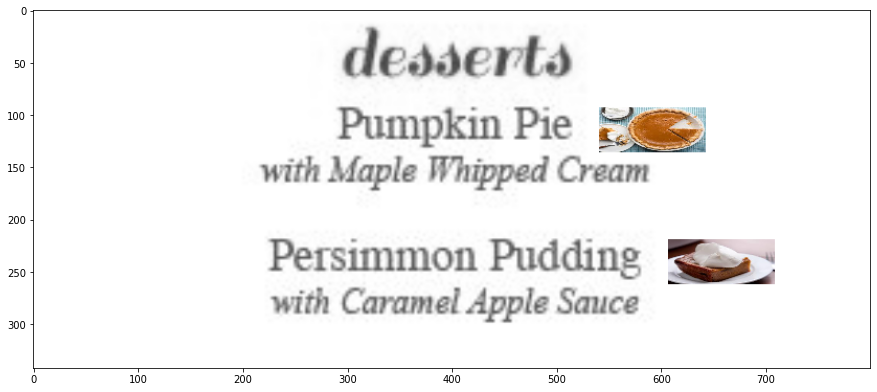

In [61]:
resturant_menu_expert('../img/test.jpg' ,4)